In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [ ]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

In [ ]:
isess = tf.InteractiveSession()

# Drawing and plotting routines.

In [ ]:
def bboxes_draw_on_img(img, scores, bboxes, colors, thickness=2, show_text=True):
    """Drawing bounding boxes on an image, with additional text if wanted...
    """
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[i % len(colors)]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        if show_text:
            s = '%s: %s' % ('Car', scores[i])    
            p1 = (p1[0]-5, p1[1])
            cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
        
def plot_image(img, title='', figsize=(24, 9)):
    f, axes = plt.subplots(1, 1, figsize=figsize)
    f.tight_layout()
    axes.imshow(img)
    axes.set_title(title, fontsize=20)

# SSD TensorFlow Network

Build up the convolutional network and load the checkpoint.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection')
print(sys.path)

['/tensorflow-1.15.2/python3.7', '', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection']


In [ ]:
from nets import ssd_vgg_300
from nets import ssd_common
from preprocessing import ssd_vgg_preprocessing

ckpt_filename = '/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection/checkpoints/model.ckpt-5181'
ckpt_filename = '/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection/checkpoints/ssd_model.ckpt'

In [ ]:
# Input placeholder.
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, (None, None), resize=ssd_vgg_preprocessing.Resize.NONE)
image_4d = tf.expand_dims(image_pre, 0)

# Network parameters.
params = ssd_vgg_300.SSDNet.default_params
params = params._replace(num_classes=8)

# SSD network construction.
reuse = True if 'ssd' in locals() else None
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [ ]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)

# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)
# Save back model to clean the checkpoint?
save_clean = False
if save_clean:
    ckpt_filename_save = '/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection/checkpoints/ssd_model.ckpt'
    saver.save(isess, ckpt_filename_save, write_meta_graph=True, write_state=True)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection/checkpoints/ssd_model.ckpt


# Image Pipeline

Presenting the different steps of the vehicle detection pipeline.

In [ ]:
# Main SSD processing routine.
def ssd_process_image(img, select_threshold=0.5):
    """Process an image through SSD network.
    
    Arguments:
      img: Numpy array containing an image.
      select_threshold: Classification threshold (i.e. probability threshold for car detection).
    Return:
      rclasses, rscores, rbboxes: Classes, scores and bboxes of objects detected.
    """
    # Resize image to height 300.
    factor = 300. / float(img.shape[0])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor) 
    # Run SSD network and get class prediction and localization.
    rpredictions, rlocalisations = isess.run([predictions, localisations], feed_dict={img_input: img})
    
    # Get anchor boxes for this image shape.
    ssd.update_feature_shapes(rpredictions)
    anchors = ssd.anchors(img.shape, dtype=np.float32)
    
    # Compute classes and bboxes from the net outputs: decode SSD output.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            threshold=select_threshold, img_shape=img.shape, num_classes=ssd.params.num_classes, decode=True)
    
    # Remove other classes than cars.
    idxes = (rclasses == 1)
    rclasses = rclasses[idxes]
    rscores = rscores[idxes]
    rbboxes = rbboxes[idxes]
    # Sort boxes by score.
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    return rclasses, rscores, rbboxes

## Load sample image

Shape: (720, 1280, 3)


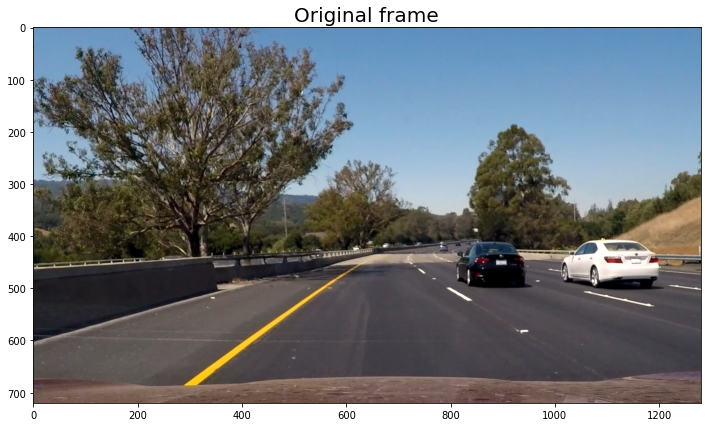

In [ ]:
# Load a sample image.
path = '/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection/test_images/'
image_names = sorted(os.listdir(path))
img = mpimg.imread(path + image_names[5])

print('Shape:', img.shape)
plot_image(img, 'Original frame', (10, 10))

## Raw SSD output: multiple detections after simple thresholding

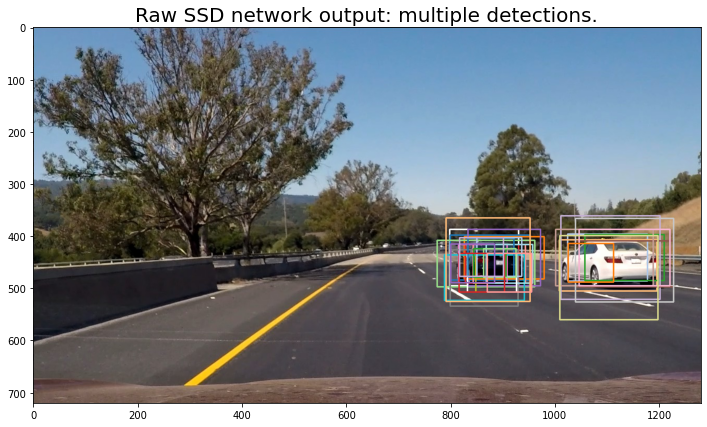

In [ ]:
# SSD network on image.
rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
# Draw bboxes of detected objects.
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)

plot_image(img_bboxes, 'Raw SSD network output: multiple detections.', (10, 10))

In [ ]:
def bboxes_overlap(bbox, bboxes):
    """Computing overlap score between bboxes1 and bboxes2.
    Note: bboxes1 can be multi-dimensional.
    """
    if bboxes.ndim == 1:
        bboxes = np.expand_dims(bboxes, 0)
    # Intersection bbox and volume.
    int_ymin = np.maximum(bboxes[:, 0], bbox[0])
    int_xmin = np.maximum(bboxes[:, 1], bbox[1])
    int_ymax = np.minimum(bboxes[:, 2], bbox[2])
    int_xmax = np.minimum(bboxes[:, 3], bbox[3])

    int_h = np.maximum(int_ymax - int_ymin, 0.)
    int_w = np.maximum(int_xmax - int_xmin, 0.)
    int_vol = int_h * int_w
    # Union volume.
    vol1 = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    vol2 = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    score1 = int_vol / vol1
    score2 = int_vol / vol2
    return np.maximum(score1, score2)


def bboxes_nms_intersection_avg(classes, scores, bboxes, threshold=0.5):
    """Apply non-maximum selection to bounding boxes with score averaging.
    The NMS algorithm works as follows: go over the list of boxes, and for each, see if
    boxes with lower score overlap. If yes, averaging their scores and coordinates, and
    consider it as a valid detection.
    
    Arguments:
      classes, scores, bboxes: SSD network output.
      threshold: Overlapping threshold between two boxes.
    Return:
      classes, scores, bboxes: Classes, scores and bboxes of objects detected after applying NMS.
    """
    keep_bboxes = np.ones(scores.shape, dtype=np.bool)
    new_bboxes = np.copy(bboxes)
    new_scores = np.copy(scores)
    new_elements = np.ones_like(scores)
    for i in range(scores.size-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            sub_bboxes = bboxes[(i+1):]
            sub_scores = scores[(i+1):]
            overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
            mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])
            while np.sum(mask):
                keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], ~mask)
                # Update boxes...
                tmp_scores = np.reshape(sub_scores[mask], (sub_scores[mask].size, 1))
                new_bboxes[i] = new_bboxes[i] * new_scores[i] + np.sum(sub_bboxes[mask] * tmp_scores, axis=0)
                new_scores[i] += np.sum(sub_scores[mask])
                new_bboxes[i] = new_bboxes[i] / new_scores[i]
                new_elements[i] += np.sum(mask)
                
                # New overlap with the remaining?
                overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
                mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])

    new_scores = new_scores / new_elements
    idxes = np.where(keep_bboxes)
    return classes[idxes], new_scores[idxes], new_bboxes[idxes]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


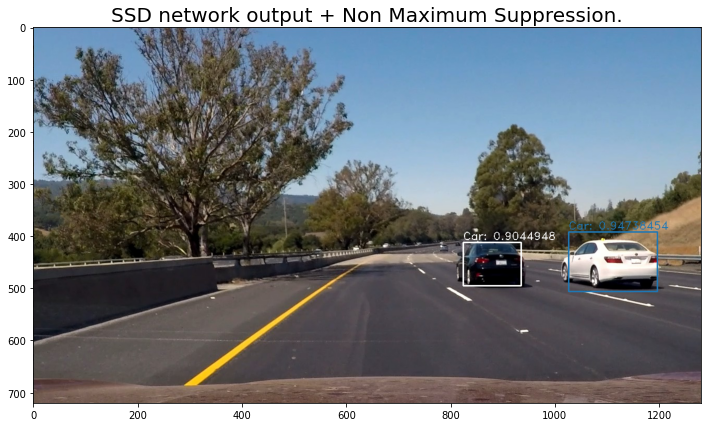

In [ ]:
# Apply Non-Maximum-Selection
nms_threshold = 0.5
rclasses_nms, rscores_nms, rbboxes_nms = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)

# Draw bboxes
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rscores_nms, rbboxes_nms, colors_tableau, thickness=2)

plot_image(img_bboxes, 'SSD network output + Non Maximum Suppression.', (10, 10))

# Vehicle detection: images

In [ ]:
def process_image(img, select_threshold=0.8, nms_threshold=0.5):
    # SSD network + NMS on image.
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold)
    rclasses, rscores, rbboxes = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Draw bboxes of detected objects.
    bboxes_draw_on_img(img, rscores, rbboxes, colors_tableau, thickness=2, show_text=True)
    return img

# Load a sample image.
path = '/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection/test_images/'
outpath = '/content/drive/MyDrive/Notebooks/AIFFELTHON/SDC-Vehicle-Detection/output_images/'
image_names = sorted(os.listdir(path))
for name in image_names:
    print(name)
    img = mpimg.imread(path + name)
    img = process_image(img, select_threshold=0.6, nms_threshold=0.5)
    mpimg.imsave(outpath + name, img, format='jpg')

test1.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg
